In [1]:
import numpy as np
np.set_printoptions(precision=3)

import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

import sys
sys.path.append("..")
import solax as sx

In [2]:
def build_bath(N_bath):
    ii = np.arange(N_bath) + 1
    xx = ii * np.pi / (N_bath + 1)
    e_bath = -2 * np.cos(xx)
    
    V0 = np.sqrt(20 / (N_bath + 1))
    V_bath = V0 * np.sqrt(1 - (e_bath / 2)**2)
    
    return e_bath, V_bath

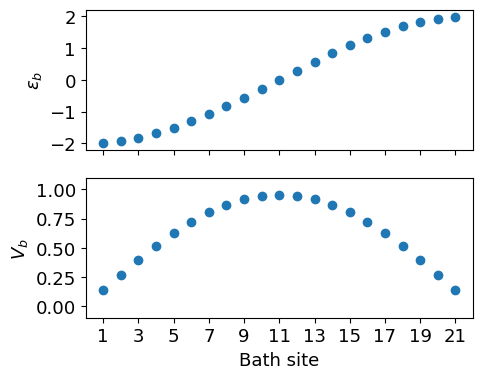

In [3]:
e_bath, V_bath = build_bath(N_bath=21)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 4))

ii = np.arange(1, len(e_bath) + 1)

ax = axes[0]
ax.scatter(ii, e_bath)
ax.set_ylabel(r"$\varepsilon_b$");
ax.set_ylim(-2.2, 2.2)
ax.set_yticks(np.arange(-2.0, 2.1))

ax = axes[1]
ax.scatter(ii, V_bath)
ax.set_ylabel(r"$V_b$");
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_ylim(-0.1, 1.1)

ax.set_xlabel("Bath site");
ax.set_xticks(ii[::2]);

In [4]:
def build_start_dets(N_bath):
    det1 = "01"  + "1" * (N_bath - 1) + "10" + "0" * (N_bath - 1)
    det2 = "10"  + "1" * (N_bath - 1) + "01" + "0" * (N_bath - 1)
    return det1, det2

In [5]:
U = 10
N_bath = 3
e_bath, V_bath = build_bath(N_bath)
start_dets = build_start_dets(N_bath)

In [6]:
basis_start = sx.Basis(build_start_dets(N_bath))
print(basis_start)

01111000
10110100


In [7]:
H_imp2 = sx.Operator(
    (1, 0, 1, 0),
    np.array([
        [0, 0, 1, 1]
    ]),
    np.array([U])
)

H_imp1 = sx.Operator(
    (1, 0),
    np.array([
        [0, 0],
        [1, 1]
    ]),
    np.array([-U / 2, -U / 2])
)

H_imp = H_imp2 + H_imp1 + U / 4
print(H_imp)

Operator({
	(1, 0): OperatorTerm(
		daggers=(1, 0),
		posits=array([[0, 0],
		       [1, 1]]),
		coeffs=array([-5., -5.])
	),
	scalar: 2.5,
	(1, 0, 1, 0): OperatorTerm(
		daggers=(1, 0, 1, 0),
		posits=array([[0, 0, 1, 1]]),
		coeffs=array([10.])
	)
})


In [8]:
H_bath = sx.Operator(
    (1, 0),
    np.arange(2, 2 * N_bath + 2).repeat(2).reshape(-1, 2),
    e_bath.repeat(2)
)
print(H_bath)

Operator({
	(1, 0): OperatorTerm(
		daggers=(1, 0),
		posits=array([[2, 2],
		       [3, 3],
		       [4, 4],
		       [5, 5],
		       [6, 6],
		       [7, 7]]),
		coeffs=array([-1.414e+00, -1.414e+00, -1.225e-16, -1.225e-16,  1.414e+00,
		        1.414e+00])
	)
})


In [9]:
H_hyb_posits = np.vstack([
    np.array([0, 1] * N_bath),
    np.arange(2, 2 * N_bath + 2)
]).T

H_hyb_nohc = sx.Operator(
    (1, 0),
    H_hyb_posits,
    V_bath.repeat(2)
)
print(H_hyb_nohc)

Operator({
	(1, 0): OperatorTerm(
		daggers=(1, 0),
		posits=array([[0, 2],
		       [1, 3],
		       [0, 4],
		       [1, 5],
		       [0, 6],
		       [1, 7]]),
		coeffs=array([1.581, 1.581, 2.236, 2.236, 1.581, 1.581])
	)
})


In [10]:
H = H_imp + H_bath + H_hyb_nohc + H_hyb_nohc.hconj

In [11]:
matrix_start = H.build_matrix(basis_start)

2024-08-20 15:53:19.810451: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [12]:
matrix_dense_start = matrix_start.to_scipy().todense()
print(matrix_dense_start)

[[-5.328  0.   ]
 [ 0.    -5.328]]


In [13]:
energy_start = matrix_dense_start[0, 0]
print(energy_start)

-5.32842712474619


In [14]:
basis = H(basis_start)
print(len(basis))

8


In [15]:
matrix = H.build_matrix(basis)

matrix_dense = matrix.to_scipy().todense()
print(matrix_dense)

[[-5.328 -1.581 -2.236 -2.236 -1.581  0.     0.     0.   ]
 [-1.581  1.086  0.     0.     0.     0.     0.     0.   ]
 [-2.236  0.    -0.328  0.     0.     2.236  0.     0.   ]
 [-2.236  0.     0.    -0.328  0.     2.236  0.     0.   ]
 [-1.581  0.     0.     0.     1.086  0.     0.     0.   ]
 [ 0.     0.     2.236  2.236  0.    -5.328 -1.581 -1.581]
 [ 0.     0.     0.     0.     0.    -1.581  1.086  0.   ]
 [ 0.     0.     0.     0.     0.    -1.581  0.     1.086]]


In [16]:
energy = np.linalg.eigvals(matrix_dense).min()

basis_size = len(basis)
print(f"Basis size = {basis_size}\tEnergy = {energy}")

Basis size = 8	Energy = -8.351171437060554


In [17]:
U = 10
N_bath = 21
e_bath, V_bath = build_bath(N_bath)
start_dets = build_start_dets(N_bath)

basis_start = sx.Basis(build_start_dets(N_bath))

H_imp2 = sx.Operator(
    (1, 0, 1, 0),
    np.array([
        [0, 0, 1, 1]
    ]),
    np.array([U])
)

H_imp1 = sx.Operator(
    (1, 0),
    np.array([
        [0, 0],
        [1, 1]
    ]),
    np.array([-U / 2, -U / 2])
)

H_imp = H_imp2 + H_imp1 + U / 4

H_bath = sx.Operator(
    (1, 0),
    np.arange(2, 2 * N_bath + 2).repeat(2).reshape(-1, 2),
    e_bath.repeat(2)
)

H_hyb_posits = np.vstack([
    np.array([0, 1] * N_bath),
    np.arange(2, 2 * N_bath + 2)
]).T

H_hyb_nohc = sx.Operator(
    (1, 0),
    H_hyb_posits,
    V_bath.repeat(2)
)

H = H_imp + H_bath + H_hyb_nohc + H_hyb_nohc.hconj

In [18]:
num_iterations = 4

basis = basis_start

for i in range(num_iterations):
    matrix = H.build_matrix(basis)
    energy = sp.sparse.linalg.eigsh(
        matrix.to_scipy(), k=1, which="SA"
    )[0][0]
    
    basis_size = len(basis)
    print(
        f"Iteration: {i+1:<8d}"
        f"Basis size = {basis_size:<12d}"
        f"Energy = {energy}"
    )
    
    if i < num_iterations - 1:
        basis = H(basis)

Iteration: 1       Basis size = 2           Energy = -28.463653910211487
Iteration: 2       Basis size = 44          Energy = -30.19530217404953
Iteration: 3       Basis size = 684         Energy = -31.242891311317663
Iteration: 4       Basis size = 7084        Energy = -31.70729257122757


In [19]:
basis_small = basis
M_small = matrix
print(M_small.size)

(7084, 7084)


In [20]:
basis_big = H(basis_small)
M_big_direct = H.build_matrix(basis_big)
print(M_big_direct.size)

(58984, 58984)


In [21]:
print(len(basis_small % basis_big) == 0)

True


In [22]:
basis_cols = basis_big % basis_small
basis_rows = basis_small + basis_cols

In [23]:
C = H.build_matrix(basis_rows, basis_cols)
print(C.size)

(58984, 51900)


In [24]:
C_displ = C.displace(0, len(basis_small))

In [25]:
M_with2B = M_small + C_displ + C_displ.hconj

In [26]:
left_top = (len(basis_small), len(basis_small))
right_bottom = (None, None)

B_displ = C_displ.window(left_top, right_bottom)

In [27]:
M_big = M_with2B - B_displ

In [28]:
energy_big_direct = sp.sparse.linalg.eigsh(M_big_direct.to_scipy(), k=1, which="SA")[0][0]
print(energy_big_direct)

-31.81901863948388


In [29]:
energy_big = sp.sparse.linalg.eigsh(M_big.to_scipy(), k=1, which="SA")[0][0]
print(energy_big)

-31.819018639483822
